In [1]:
from pandas.tseries.offsets import BDay
import requests
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
def fetch_data(url):
    response = requests.get(url)
    if response.status_code != 200:
        print("Error fetching data:", response.status_code, response.text)
        return None
    data = response.json()
    if 'results' not in data:
        print("No 'results' key in response:", data)
        return None
    return data

def calculate_daily_returns(df, prev_close=None):
    if prev_close is not None:
        df.loc[df.index[0], 'prev_close'] = prev_close
    else:
        df['prev_close'] = df['c'].shift(1)
    df['daily_return'] = (df['c'] - df['prev_close']) / df['prev_close']
    df['abs_daily_return'] = df['daily_return'].abs()
    return df

def get_top_outliers(df, n=10):
    return df.nlargest(n, 'abs_daily_return')

def update_outliers_list(current_df, historical_outliers_df, real_time_outliers_df, n=10):
    if 'source' not in current_df.columns:
        current_df['source'] = 'real-time'
    combined_df = pd.concat([historical_outliers_df, current_df])
    updated_outliers_df = combined_df.nlargest(n, 'abs_daily_return')
    updated_historical_outliers_df = updated_outliers_df[updated_outliers_df['source'] == 'historical']
    updated_real_time_outliers_df = updated_outliers_df[updated_outliers_df['source'] == 'real-time']
    return updated_historical_outliers_df, updated_real_time_outliers_df

def convert_timestamps(df):
    df['date'] = pd.to_datetime(df['t'], unit='ms')
    df.drop(columns=['t'], inplace=True)
    return df

# API key and endpoints
api_key = 'beBybSi8daPgsTp5yx5cHtHpYcrjp5Jq'
today = pd.Timestamp.now().date()
start_date = today - pd.DateOffset(years=1)
start_date_formatted = start_date.strftime('%Y-%m-%d')
end_date = today - pd.DateOffset(days=1)
end_date_formatted = end_date.strftime('%Y-%m-%d')
symbol = 'C:USDCHF'
historical_url = f'https://api.polygon.io/v2/aggs/ticker/{symbol}/range/1/day/{start_date_formatted}/{end_date_formatted}?adjusted=true&sort=asc&apiKey={api_key}'
real_time_url = f'https://api.polygon.io/v2/aggs/ticker/{symbol}/range/1/day/{today}/{today}?adjusted=true&sort=asc&apiKey={api_key}'

# Fetch and process historical data
historical_data = fetch_data(historical_url)
if historical_data:
    historical_df = pd.DataFrame(historical_data['results'])
    historical_df = convert_timestamps(historical_df)
    historical_df = calculate_daily_returns(historical_df)
    historical_df['source'] = 'historical'
    historical_outliers_df = get_top_outliers(historical_df)
else:
    print("Failed to fetch or process historical data.")

# Fetch and process real-time data
real_time_data = fetch_data(real_time_url)
if real_time_data and 'results' in real_time_data:
    real_time_df = pd.DataFrame(real_time_data['results'])
    real_time_df = convert_timestamps(real_time_df)
    # Use the last close from historical data
    last_close = historical_df['c'].iloc[-1] if not historical_df.empty else None
    real_time_df = calculate_daily_returns(real_time_df, prev_close=last_close)
    real_time_df['source'] = 'real-time'
    updated_historical_outliers_df, updated_real_time_outliers_df = update_outliers_list(real_time_df, historical_outliers_df, pd.DataFrame())
    # Update historical data
    historical_df = pd.concat([historical_df.iloc[1:], real_time_df])  # Keep historical data rolling
else:
    print("No new data available or failed to fetch real-time data.")

# Combine data for Top 10 Outliers
full_outlier_df = pd.concat([updated_historical_outliers_df, updated_real_time_outliers_df])

# Print the Outliers
full_outlier_df

,v,vw,o,c,h,l,n,date,prev_close,daily_return,abs_daily_return,source
300,216451,0.8664,0.87294,0.857700,0.87336,0.85710,216451,2024-08-02,0.87294,-0.017458,0.017458,historical
185,187960,0.8932,0.88558,0.897500,0.89937,0.88360,187960,2024-03-21,0.88555,0.013494,0.013494,historical
69,168024,0.8965,0.90127,0.889100,0.90271,0.88750,168024,2023-11-14,0.90120,-0.013427,0.013427,historical
153,191642,0.8825,0.87580,0.887420,0.88810,0.87520,191642,2024-02-13,0.87581,0.013256,0.013256,historical
112,174820,0.8495,0.85359,0.842500,0.85487,0.84060,174820,2023-12-27,0.85372,-0.013142,0.013142,historical
286,160058,0.8871,0.89375,0.881950,0.89411,0.88166,160058,2024-07-17,0.89338,-0.012794,0.012794,historical
202,159390,0.9089,0.90297,0.913140,0.91470,0.90260,159390,2024-04-10,0.90303,0.011196,0.011196,historical
245,172177,0.9074,0.91319,0.903320,0.91408,0.90053,172177,2024-05-30,0.91311,-0.010722,0.010722,historical
144,184263,0.8610,0.85760,0.866698,0.86820,0.85510,184263,2024-02-02,0.85760,0.010609,0.010609,historical
315,164709,0.8591,0.86242,0.853540,0.86257,0.85190,164709,2024-08-20,0.86254,-0.010434,0.010434,historical


In [3]:
sorted_outliers_data = full_outlier_df.sort_values(by="date")
sorted_outliers_data

,v,vw,o,c,h,l,n,date,prev_close,daily_return,abs_daily_return,source
69,168024,0.8965,0.90127,0.889100,0.90271,0.88750,168024,2023-11-14,0.90120,-0.013427,0.013427,historical
112,174820,0.8495,0.85359,0.842500,0.85487,0.84060,174820,2023-12-27,0.85372,-0.013142,0.013142,historical
144,184263,0.8610,0.85760,0.866698,0.86820,0.85510,184263,2024-02-02,0.85760,0.010609,0.010609,historical
153,191642,0.8825,0.87580,0.887420,0.88810,0.87520,191642,2024-02-13,0.87581,0.013256,0.013256,historical
185,187960,0.8932,0.88558,0.897500,0.89937,0.88360,187960,2024-03-21,0.88555,0.013494,0.013494,historical
202,159390,0.9089,0.90297,0.913140,0.91470,0.90260,159390,2024-04-10,0.90303,0.011196,0.011196,historical
245,172177,0.9074,0.91319,0.903320,0.91408,0.90053,172177,2024-05-30,0.91311,-0.010722,0.010722,historical
286,160058,0.8871,0.89375,0.881950,0.89411,0.88166,160058,2024-07-17,0.89338,-0.012794,0.012794,historical
300,216451,0.8664,0.87294,0.857700,0.87336,0.85710,216451,2024-08-02,0.87294,-0.017458,0.017458,historical
315,164709,0.8591,0.86242,0.853540,0.86257,0.85190,164709,2024-08-20,0.86254,-0.010434,0.010434,historical


In [4]:
# Convert dates in dataset to datetime objects
sorted_outliers_data['date'] = pd.to_datetime(sorted_outliers_data['date'])

date_ranges = pd.DataFrame({
    "start_date": sorted_outliers_data['date'] - BDay(14), # To predict X days, keep this as X-1 (as 1 day of outlier will be considered in LSTM input)
    "end_date": sorted_outliers_data['date'] + BDay(15),
    "outlier_date": sorted_outliers_data['date'],
})

date_ranges

,start_date,end_date,outlier_date
69,2023-10-25,2023-12-05,2023-11-14
112,2023-12-07,2024-01-17,2023-12-27
144,2024-01-15,2024-02-23,2024-02-02
153,2024-01-24,2024-03-05,2024-02-13
185,2024-03-01,2024-04-11,2024-03-21
202,2024-03-21,2024-05-01,2024-04-10
245,2024-05-10,2024-06-20,2024-05-30
286,2024-06-27,2024-08-07,2024-07-17
300,2024-07-15,2024-08-23,2024-08-02
315,2024-07-31,2024-09-10,2024-08-20


In [5]:
def calculate_daily_returns(df, prev_close=None):
    if prev_close is not None:
        df.loc[df.index[0], 'prev_close'] = prev_close
    else:
        df['prev_close'] = df['c'].shift(1)
    df['daily_return'] = (df['c'] - df['prev_close']) / df['prev_close']
    df['abs_daily_return'] = df['daily_return'].abs()
    return df

def fetch_daily_data(symbol, start_date, end_date, api_key):
    formatted_start_date = start_date.strftime('%Y-%m-%d')
    formatted_end_date = end_date.strftime('%Y-%m-%d')

    url = f"https://api.polygon.io/v2/aggs/ticker/{symbol}/range/1/day/{formatted_start_date}/{formatted_end_date}?adjusted=true&sort=asc&apiKey={api_key}"
    response = requests.get(url)

    if response.status_code != 200:
        print(f"Failed to fetch data: {response.status_code} - {response.text}")
        return None

    response_data = response.json()

    if 'results' not in response_data:
        print(f"No 'results' in response: {response_data}")
        return None

    df = pd.DataFrame(response_data['results'])
    df['date'] = pd.to_datetime(df['t'], unit='ms')
    df.drop(columns=['t'], inplace=True)

    daily_data = calculate_daily_returns(df)
    daily_data.set_index('date', inplace=True)

    return daily_data

def fetch_and_process_daily_data(symbol, start_date, end_date, api_key):
    daily_data = fetch_daily_data(symbol, start_date, end_date, api_key)

    if daily_data is None:
        print("No data fetched")
        return None

    daily_data.reset_index(inplace=True)
    return daily_data

In [6]:
# Initialize an outlier identifier starting from 1 or any specific number
outlier_id = 1

# Convert start_date, end_date, and outlier_date to Timestamp for consistent comparison
start_date_co = pd.Timestamp(date_ranges['start_date'].iloc[-3])
end_date_co = pd.Timestamp(date_ranges['end_date'].iloc[-3]) + pd.Timedelta(days=1)  # Extend the end date by one additional day
outlier_date_co = pd.Timestamp(date_ranges['outlier_date'].iloc[-3])

# Get daily data for the range including 3 days before and after the outlier
daily_data = fetch_and_process_daily_data(symbol, start_date_co, end_date_co, api_key)

# Assign the current outlier_id to the data
daily_data['outlier_id'] = outlier_id

# Filter out weekends
daily_data = daily_data[~daily_data['date'].dt.weekday.isin([5, 6])]

# prior_data from start_date to outlier_date inclusive
df_prior = daily_data[(daily_data['date'] >= start_date_co) & (daily_data['date'] < outlier_date_co)]
df_prior["day type"] = "prior day"

# outlier_data is for the daily data on the day of the outlier
df_outlier = daily_data[daily_data['date'].dt.date == outlier_date_co.date()]
df_outlier["day type"] = "outlier day"

# post_data from the day after outlier_date to end_date
post_outlier_co = outlier_date_co + pd.Timedelta(days=1)  # Starting the day after the outlier_date
df_post = daily_data[(daily_data['date'] >= post_outlier_co) & (daily_data['date'] < end_date_co)]
df_post["day type"] = "post day"

# Combine all data into a single DataFrame
new_df = pd.concat([df_prior, df_outlier, df_post], axis=0)

new_df

/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_22927/2807039802.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prior["day type"] = "prior day"
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_22927/2807039802.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outlier["day type"] = "outlier day"
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_22927/2807039802.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

,date,v,vw,o,c,h,l,n,prev_close,daily_return,abs_daily_return,outlier_id,day type
0,2024-06-27,147731,0.8973,0.89704,0.898520,0.898880,0.89550,147731,NaN,NaN,NaN,1,prior day
1,2024-06-28,149653,0.8991,0.89853,0.898526,0.900970,0.89770,149653,0.89852,0.000007,0.000007,1,prior day
3,2024-07-01,141139,0.9012,0.90033,0.903210,0.904500,0.89810,141139,0.90034,0.003188,0.003188,1,prior day
4,2024-07-02,146719,0.9040,0.90316,0.903700,0.904960,0.90154,146719,0.90321,0.000543,0.000543,1,prior day
5,2024-07-03,120113,0.9023,0.90372,0.900720,0.905030,0.89830,120113,0.90370,-0.003298,0.003298,1,prior day
6,2024-07-04,120106,0.9006,0.90076,0.900200,0.903910,0.89890,120106,0.90072,-0.000577,0.000577,1,prior day
7,2024-07-05,145691,0.8980,0.90025,0.895400,0.900550,0.89500,145691,0.90020,-0.005332,0.005332,1,prior day
9,2024-07-08,140062,0.8959,0.89527,0.897500,0.898300,0.89410,140062,0.89523,0.002536,0.002536,1,prior day
10,2024-07-09,138199,0.8979,0.89781,0.897560,0.899050,0.89640,138199,0.89750,0.000067,0.000067,1,prior day
11,2024-07-10,132972,0.8983,0.89757,0.899100,0.900200,0.89610,132972,0.89756,0.001716,0.001716,1,prior day


In [7]:
sorted_df = new_df.sort_values(by='date', ascending=True)
sorted_df.fillna(method='bfill', inplace=True)
sorted_df.fillna(method='ffill', inplace=True)

sorted_df

/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_22927/1957119371.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sorted_df.fillna(method='bfill', inplace=True)
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_22927/1957119371.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sorted_df.fillna(method='ffill', inplace=True)


,date,v,vw,o,c,h,l,n,prev_close,daily_return,abs_daily_return,outlier_id,day type
0,2024-06-27,147731,0.8973,0.89704,0.898520,0.898880,0.89550,147731,0.89852,0.000007,0.000007,1,prior day
1,2024-06-28,149653,0.8991,0.89853,0.898526,0.900970,0.89770,149653,0.89852,0.000007,0.000007,1,prior day
3,2024-07-01,141139,0.9012,0.90033,0.903210,0.904500,0.89810,141139,0.90034,0.003188,0.003188,1,prior day
4,2024-07-02,146719,0.9040,0.90316,0.903700,0.904960,0.90154,146719,0.90321,0.000543,0.000543,1,prior day
5,2024-07-03,120113,0.9023,0.90372,0.900720,0.905030,0.89830,120113,0.90370,-0.003298,0.003298,1,prior day
6,2024-07-04,120106,0.9006,0.90076,0.900200,0.903910,0.89890,120106,0.90072,-0.000577,0.000577,1,prior day
7,2024-07-05,145691,0.8980,0.90025,0.895400,0.900550,0.89500,145691,0.90020,-0.005332,0.005332,1,prior day
9,2024-07-08,140062,0.8959,0.89527,0.897500,0.898300,0.89410,140062,0.89523,0.002536,0.002536,1,prior day
10,2024-07-09,138199,0.8979,0.89781,0.897560,0.899050,0.89640,138199,0.89750,0.000067,0.000067,1,prior day
11,2024-07-10,132972,0.8983,0.89757,0.899100,0.900200,0.89610,132972,0.89756,0.001716,0.001716,1,prior day


In [8]:
# Split the dataset
train_set = sorted_df.iloc[:15].reset_index(drop=True) # Change iloc positions for 10 days prediction, use ":10"
test_set = sorted_df.iloc[15:].reset_index(drop=True) # Change iloc positions for 10 days prediction, use "10:"

# Reset index if needed
train_set = train_set.reset_index(drop=True)
test_set = test_set.reset_index(drop=True)

In [9]:
sequence_length = 12  # Example sequence length for LSTM model - 10 daily value days - 10 sequence length

# Filter data for the single outlier_id
outlier_id = train_set["outlier_id"].unique()[0]
train_df = train_set[train_set["outlier_id"] == outlier_id].set_index("date")
train_df.index = pd.to_datetime(train_df.index)  # Convert index to DateTimeIndex
test_df = test_set[test_set["outlier_id"] == outlier_id]

# Normalize data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df[["c"]])

# Prepare data for LSTM model
train_generator = TimeseriesGenerator(train_scaled, train_scaled, length=sequence_length, batch_size=1)

# Define and compile LSTM model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(sequence_length, 1)),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

# Fit the model
model.fit(train_generator, epochs=100, verbose=0)

# Prepare last sequence for forecasting
last_sequence = train_scaled[-sequence_length:]

# Iteratively forecast the next 240 steps - 10 daily value days - 10 sequence length
forecast_steps = 12
predictions_scaled = []
for _ in range(forecast_steps):
    # Reshape the last sequence for prediction
    last_sequence_reshaped = last_sequence.reshape((1, sequence_length, 1))
    # Predict the next step and append to predictions
    next_step_pred = model.predict(last_sequence_reshaped, verbose=0)
    predictions_scaled.append(next_step_pred.ravel()[0])
    # Update the last sequence with the prediction
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = next_step_pred

# Inverse transform predictions
predictions_inv = scaler.inverse_transform(np.array(predictions_scaled).reshape(-1, 1))

# Compute metrics for the single outlier_id
actuals = test_df["c"].values[:forecast_steps]

mse = mean_squared_error(actuals, predictions_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actuals, predictions_inv)
mape = mean_absolute_percentage_error(actuals, predictions_inv)
r2 = r2_score(actuals, predictions_inv)

# Calculate sMAPE
smape = np.mean(2 * np.abs(predictions_inv - actuals) / (np.abs(predictions_inv) + np.abs(actuals))) * 100

# Print metrics
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("MAPE:", mape)
print("sMAPE:", smape)
print("R^2:", r2)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


MAE: 0.006385572059949228
MSE: 0.00010042960369116967
RMSE: 0.010021457164064
MAPE: 0.007327526682216507
sMAPE: 0.7681131637141574
R^2: -0.2848949695048626


In [10]:
print(len(predictions_inv), len(actuals))

12 12


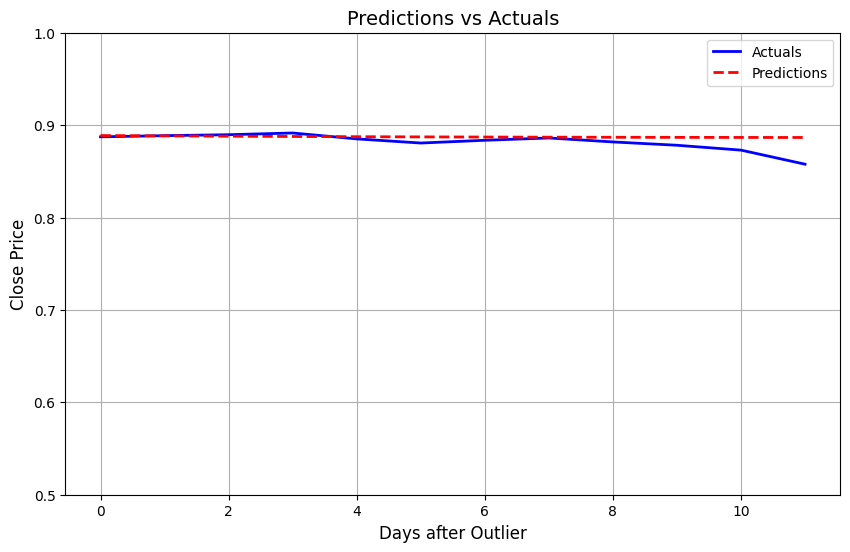

In [11]:
plt.figure(figsize=(10, 6))

# Plot actuals
plt.plot(actuals, label='Actuals', color='blue', linewidth=2)

# Plot predictions
plt.plot(predictions_inv, label='Predictions', color='red', linestyle='--', linewidth=2)

# Adding title and labels
plt.title('Predictions vs Actuals', fontsize=14)
plt.xlabel('Days after Outlier', fontsize=12)
plt.ylabel('Close Price', fontsize=12)

# Set y-axis range from 0 to 1
plt.ylim(0.5, 1)

# Show legend
plt.legend()

# Display grid
plt.grid(True)

# Show the plot
plt.show()